In [58]:
# **README**
#Tobechi Nwachukwu: 101186606
#Stephen Akinpelu : 101151897
#Kendall Daze-Yach : 101139299

#This Code is designed for AI training only, it will save the AI on train and load for testing but,
#It is NOT designed for segmented or repeated training and thus, will not load the AI prior to training

#This is a test to investigate the usefulness of two-part segmented AI architectures working together-
#To solve a more complex problem.

#Is it better to train an AI specifically for a dataset or can this be streamlined using pre-processing functions?

# **PLEASE ENSURE ALL DATA IS CREATED WITH MNIST_noise_creation.ipynb BEFORE RUNNING THIS NOTEBOOK**

In [59]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Device check
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
    
# Runtime vars
train_mode = False
batch_size = 32 # Static batch size to ensure similar testing environments
transform = transforms.ToTensor()
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform) # this may need to run twice if download fails

Using GPU: NVIDIA GeForce RTX 4090


In [60]:
# The noise functions to flip, unflip, blur and sharpen
def blur(image):
    return TF.gaussian_blur(image, (15, 15), 0.8)

def un_blur(image):
    # Ensure image is [batch_size, channels, height, width]
    needs_batch_dim = image.dim() == 2  # True if [height, width]
    needs_channel_dim = image.dim() == 3  # True if [batch_size, height, width]
    # Return image to the cpu
    image = image.cpu()
    if needs_batch_dim:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    elif needs_channel_dim:
        image = image.unsqueeze(1)  # Add channel dimension

    # Define and apply the sharpening kernel
    kernel = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    kernel = kernel.repeat(image.shape[1], 1, 1, 1)
    kernel = kernel.to(image.device)
    sharpened_image = F.conv2d(image, kernel, padding=1)

    # Convert to black and white
    sharpened_image = torch.where(sharpened_image > 0.05, 1.0, 0.0)
    # Remove the batch and channel dimensions if they were added
    if needs_batch_dim:
        sharpened_image = sharpened_image.squeeze(0).squeeze(0)
    elif needs_channel_dim:
        sharpened_image = sharpened_image.squeeze(1)
    return sharpened_image

def flip(image):
    return TF.hflip(image)

def unflip(image):
    return flip(image)

In [61]:
# A simple noise function helper, calling the proper 'anti-noise' function
def noise_correction(image, prediction):
    if prediction == 1:
        return un_blur(image)
    else:
        return unflip(image)

In [62]:
# Noise architecture
#2 convolutional layers, 2 fully connected layers
#The shapes are fairly complex, this architecture lead to the best standalone noise outcome.
#Filter count was reduced from 32->64->128 to 16->32->64 as the additional feature detection was not needed
# There are two classifications: 0-> Flip, 1-> Blur
class Noise_Net(nn.Module):
    # Initialize
    def __init__(self):
        
        # Setup filters
        super(Noise_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(512, 64)  # 64*4*4
        self.fc2 = nn.Linear(64, 2)
    # The actual work
    def forward(self, x):
        # Relu with pooling on the convolutional filters x2
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Flatten
        x = x.view(-1, 512)
        # Double fully connected (narrowing down to 2 classes)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [63]:
# MNIST architecture
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 128)  # 64*4*4
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [64]:
# Setup our custom data class to allow interaction with torch builtin functions
class ProcessedMNISTDataset(Dataset):
    def __init__(self, data_path):
        #load the processed data
        self.data = torch.load(data_path)

    def __len__(self):
        #return the number of samples in data
        return len(self.data['data'])

    def __getitem__(self, idx):
        #retrieve the image and target at the specified index
        image = self.data['data'][idx]
        target = self.data['targets'][idx]
        return image, target
    
# Our custom dataset
# Create an instance of the custom datasets
processed_dataset_train = ProcessedMNISTDataset('./data/MNIST/noisydata.pt')
processed_dataset_test = ProcessedMNISTDataset('./data/MNIST/noisy_test_data.pt')

In [65]:
#Train Function
def train_mode(model, batch_size = batch_size , noisy_data=False, epochs =10):
    print(model)
    accuracy_values=[]
    epoch_number=[]
    train_loader = 0
    test_loader = 0
    #If using our custom dataset, load it
    if noisy_data:
        # Create an instance of your custom training dataset
        train_loader = DataLoader(processed_dataset_train, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(processed_dataset_train, batch_size=batch_size, shuffle=False)
    else:
        train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    # Training loop (simplified)
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            
            #custom data needs to be squeezed to tensor
            if (noisy_data):
                data = data.squeeze(1)
                target = target.squeeze(1)
            
            if (noisy_data):
                if (type(model) == MNIST_Net):
                    target = [x //10 for x in target]
                    target = torch.tensor(target)
                else: 
                    target = [ 0 if x % 2 == 0 else 1 for x in target]
                    target = torch.tensor(target)
                    
            #Send data to deviec (ideally GPU)
            data, target = data.to(device), target.to(device)   
            #training steps
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
        #Mid train testing to collect convergence data
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                #custom data needs to be squeezed to tensor
                if (noisy_data):
                    data = data.squeeze(1)
                    target = target.squeeze(1)
                    # Extract digit and noise funtion from label (61 is digit 6 with blur)
                    if (type(model) == MNIST_Net):
                        target = [x //10 for x in target]
                        target = torch.tensor(target)
                    else: 
                        target = [ 0 if x % 2 == 0 else 1 for x in target]
                        target = torch.tensor(target)
                        
                # Send the data to the proper device
                data, target = data.to(device), target.to(device)     
                
                # Actually train the AI
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                
                # Increment accuracy 
                total += target.size(0)
                # Grab predictions from proper device
                if device ==torch.device("cuda"):
                    correct += (predicted.cpu()==target.cpu()).sum().item()
                else:
                    correct += (predicted==target).sum().item()
                    
            # Calculate and output accuracy per epoch
            TestAccuracy = 100 * correct / total
            epoch_number += [epoch+1]
            accuracy_values += [TestAccuracy]
            print('Epoch=%d Test Accuracy=%.3f' %(epoch + 1, TestAccuracy))

    print('Finished Training')
    #save the model
    if (type(model) == MNIST_Net):
        torch.save(model.state_dict(), 'mnist_model.pth')
    else:
        torch.save(model.state_dict(), 'noise_model.pth')
    return epoch_number, accuracy_values

In [66]:
#Test Function
# This is the main test function adapted to test both architectures based on parameters passed
def test_mode(model, batch_size = batch_size, shuffle = False , noisy_data=False):
    print(model)
    test_loader=0
    #If using our custom dataset, load it
    if noisy_data:
        # Create an instance of your custom training dataset
        test_loader = DataLoader(processed_dataset_train, batch_size=batch_size, shuffle=shuffle)
    else:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Check if model file exists
    if (type(model) == MNIST_Net):
        model_path = 'mnist_model.pth'
    else:
        model_path = 'noise_model.pth'
        
    if not os.path.exists(model_path):
        print("Model file not found.")
        return None
    
    # Load the state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    # Put the model in evaluation mode
    model.eval()
    
    #set up accuracy trackers
    correct = 0
    total = 0
    
    # Test the model
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            #custom data needs to be squeezed to tensor
            if (noisy_data):
                data = data.squeeze(1)
                target = target.squeeze(1)
                
            if (noisy_data):
                if (type(model) == MNIST_Net):
                    target = [x //10 for x in target]
                    target = torch.tensor(target)
                else: 
                    target = [ 0 if x % 2 == 0 else 1 for x in target]
                    target = torch.tensor(target)
                    
            # Send data and labels to proper device
            data, target = data.to(device), target.to(device)        
            
            # The actual predictions
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            #print("Actual:"  + str(target) + " AI guess:" + str(predicted))

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy

In [67]:
#Test Function Combined Architecture
def test_mode_combined(m1,m2, batch_size = batch_size, shuffle = False):
    print(m1)
    print(m2)
    test_loader=0
    # Create an instance of your custom training dataset
    test_loader = DataLoader(processed_dataset_train, batch_size=batch_size, shuffle=shuffle)
    
    # Check if models file exists
    model_path = 'mnist_model.pth'
    if not os.path.exists(model_path):
        print("Model1 file not found.")
        return None
    # Load the state dictionary
    m2.load_state_dict(torch.load(model_path, map_location=device))
    
    #second model, applied first
    model_path = 'noise_model.pth'
    if not os.path.exists(model_path):
        print("Model2 file not found.")
        return None
    # Load the state dictionary
    m1.load_state_dict(torch.load(model_path, map_location=device))
    
    # Put the model in evaluation mode
    m1.eval()
    m2.eval()
    
    # Test the model
    correct_noise, correct_MNIST, Correct_both = 0,0,0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            #custom data needs to be squeezed to tensor
            data = data.squeeze(1)
            target = target.squeeze(1)
                
            target2 = [x //10 for x in target]
            target2 = torch.tensor(target2)
            target = [ 0 if x % 2 == 0 else 1 for x in target]
            target = torch.tensor(target)
            
            # Pass data to appropriate device 
            data, target, target2 = data.to(device), target.to(device), target2.to(device)       
            # Pass to first architecture
            outputs = m1(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct_noise += (predicted == target).sum().item()
            
            # Image correction
            for x in range(len(predicted)): 
                data[x] = noise_correction(data[x], predicted[x])
                #data[x] = 
            
            # Pass to second architecture
            outputs = m2(data)
            _, predicted2 = torch.max(outputs.data, 1)
            correct_MNIST += (predicted2 == target2).sum().item()

            for acc in range(0,len(predicted)):
                if predicted[acc] == target[acc] and predicted2[acc] == target2[acc]:
                    Correct_both+=1
    # Calculate accuracy
    accuracy1 = 100 * correct_noise / total
    accuracy2 = 100 * correct_MNIST / total
    accuracy3 = 100 * Correct_both / total
    print(f'Noise accuracy: {accuracy1}%')
    print(f'MNIST accuracy: {accuracy2}%')
    print(f'Combined accuracy: {accuracy3}%')
    return accuracy1, accuracy2, accuracy3

MNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch=1 Test Accuracy=97.870
Epoch=2 Test Accuracy=99.040
Epoch=3 Test Accuracy=98.670
Epoch=4 Test Accuracy=99.020
Epoch=5 Test Accuracy=99.150
Epoch=6 Test Accuracy=99.090
Epoch=7 Test Accuracy=99.200
Epoch=8 Test Accuracy=99.230
Epoch=9 Test Accuracy=99.170
Epoch=10 Test Accuracy=99.010
Finished Training
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] | [97.87, 99.04, 98.67, 99.02, 99.15, 99.09, 99.2, 99.23, 99.17, 99.01]


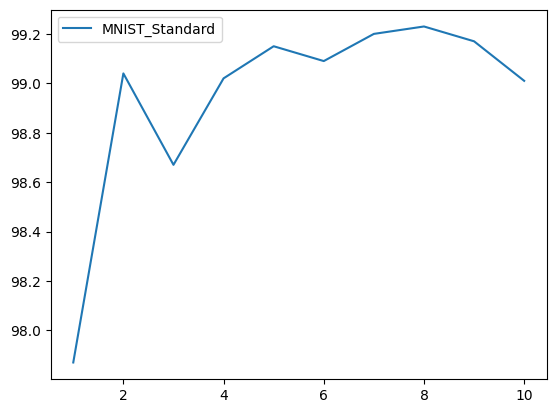

In [68]:
# MNIST Standalone
model1 = MNIST_Net()
model1 = model1.to(device)

#Standard MNIST train test
epochs, accuracies = train_mode(model1)

# Print out graph
print (str(epochs) + " | " +  str(accuracies))
plt.plot(epochs, accuracies, label='MNIST_Standard')

# Add a legend
plt.legend()

In [69]:
# MNIST Standalone, test on noisy data
# Test
standalone_acc = test_mode(model1, noisy_data=True)

MNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Accuracy: 67.575%


Noise_Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)
Epoch=1 Test Accuracy=99.997
Epoch=2 Test Accuracy=100.000
Epoch=3 Test Accuracy=100.000
Epoch=4 Test Accuracy=100.000
Epoch=5 Test Accuracy=100.000
Epoch=6 Test Accuracy=100.000
Epoch=7 Test Accuracy=100.000
Epoch=8 Test Accuracy=100.000
Epoch=9 Test Accuracy=100.000
Epoch=10 Test Accuracy=100.000
Finished Training
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] | [99.99666666666667, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


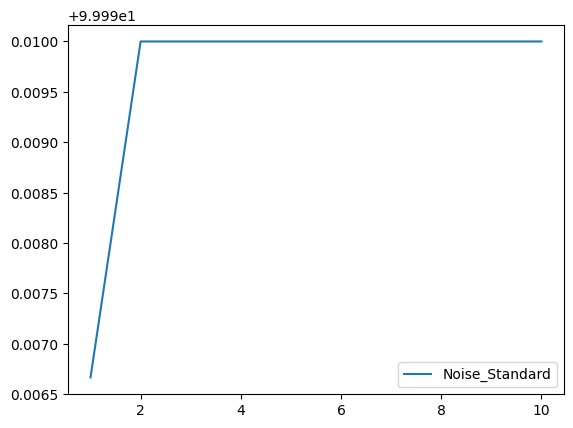

In [70]:
# Noise Standalone
model2 = Noise_Net()
model2 = model2.to(device)

#Standard MNIST train test
epochs, accuracies = train_mode(model2, noisy_data=True)

# Print out graph
print (str(epochs) + " | " +  str(accuracies))
plt.plot(epochs, accuracies, label='Noise_Standard')

# Add a legend
plt.legend()

MNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch=1 Test Accuracy=97.015
Epoch=2 Test Accuracy=97.908
Epoch=3 Test Accuracy=98.368
Epoch=4 Test Accuracy=99.248
Epoch=5 Test Accuracy=99.468
Epoch=6 Test Accuracy=99.253
Epoch=7 Test Accuracy=99.600
Epoch=8 Test Accuracy=99.635
Epoch=9 Test Accuracy=99.750
Epoch=10 Test Accuracy=99.600
Finished Training
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] | [97.015, 97.90833333333333, 98.36833333333334, 99.24833333333333, 99.46833333333333, 99.25333333333333, 99.6, 99.635, 99.75, 99.6]


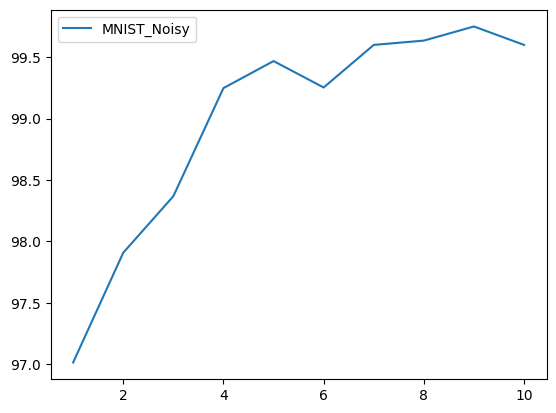

In [71]:
# MNIST train&test on noisy data
model3 = MNIST_Net()
model3 = model3.to(device)

#train
epochs, accuracies = train_mode(model3, noisy_data=True)

# Print out graph
print (str(epochs) + " | " +  str(accuracies))
plt.plot(epochs, accuracies, label='MNIST_Noisy')

# Add a legend
plt.legend()

MNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch=1 Test Accuracy=98.510
Epoch=2 Test Accuracy=98.740
Epoch=3 Test Accuracy=99.020
Epoch=4 Test Accuracy=99.070
Epoch=5 Test Accuracy=98.960
Epoch=6 Test Accuracy=99.190
Epoch=7 Test Accuracy=99.140
Epoch=8 Test Accuracy=98.980
Epoch=9 Test Accuracy=99.130
Epoch=10 Test Accuracy=99.190
Finished Training
Noise_Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)
Epoch=1 Test Accuracy=100.000
Epoch=2 Test Accuracy=99.998
Epoch=3 Test Accuracy=99.997
Epoch=4 Test Accuracy=99.998
Epoch=5 Test Accuracy=100.000
Epoch=6 Test Accuracy=100.000
Ep

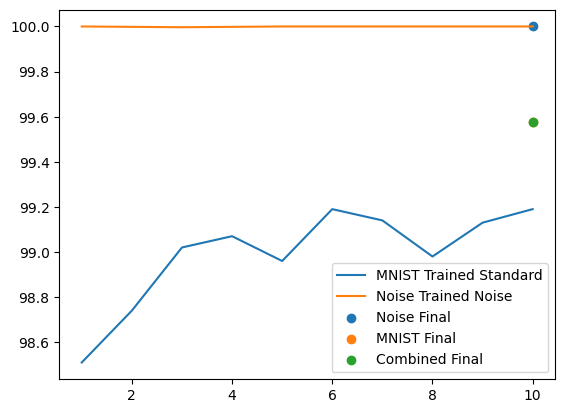

In [74]:
# MNIST, Noise Standalone train - combination test
model5 = MNIST_Net()
model5 = model5.to(device)

model6 = Noise_Net()
model6 = model6.to(device)

#Standard MNIST train test
epochs, accuracies = train_mode(model5, noisy_data=False)
epochs1, accuracies1 = train_mode(model6, noisy_data=True)

# Print out graph
print (str(epochs) + " | " +  str(accuracies))
plt.plot(epochs, accuracies, label='MNIST Trained Standard')
plt.plot(epochs1, accuracies1, label='Noise Trained Noise')

#Standard MNIST test
a1,a2,a3 = test_mode_combined(model6,model5)
# Print out graph
print (str(epochs) + " | " +  str(accuracies))
epochs3 = 10
plt.scatter(epochs3, a1, label='Noise Final')
plt.scatter(epochs3, a2, label='MNIST Final')
plt.scatter(epochs3, a3, label='Combined Final')
# Add a legend
plt.legend()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] | [98.51, 98.79, 99.23, 99.2, 99.21, 99.11, 99.17, 99.31, 99.18, 99.31]


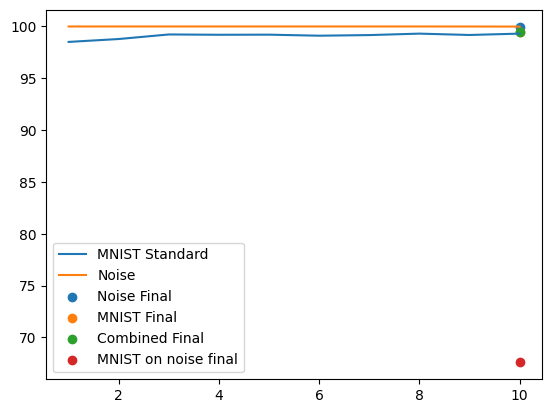

In [73]:
# Print out graph
print (str(epochs) + " | " +  str(accuracies))
plt.plot(epochs, accuracies, label='MNIST Standard')
plt.plot(epochs1, accuracies1, label='Noise')
epochs3 = 10
plt.scatter(epochs3, a1, label='Noise Final')
plt.scatter(epochs3, a2, label='MNIST Final')
plt.scatter(epochs3, a3, label='Combined Final')
plt.scatter(epochs3, standalone_acc, label='MNIST on noise final')
# Add a legend
plt.legend()